# Kenya Clinical Reasoning Challenge

This notebook explores and builds a model for the Kenya Clinical Reasoning Challenge, which focuses on predicting clinician responses to medical scenarios in rural Kenyan healthcare settings.

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Data Loading

Let's load the training and testing datasets to begin our analysis.

In [2]:
# Load the train and test datasets
train_df = pd.read_csv('/kaggle/input/kenya-clinical/train.csv')
test_df = pd.read_csv('/kaggle/input/kenya-clinical/test.csv')

# Also load the raw versions which may contain additional information
train_raw_df = pd.read_csv('/kaggle/input/kenya-clinical/train_raw.csv')
test_raw_df = pd.read_csv('/kaggle/input/kenya-clinical/test_raw.csv')

print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")

Train dataset shape: (400, 12)
Test dataset shape: (100, 7)


## Data Exploration

Let's examine the structure of our datasets and understand the clinical scenarios better.

In [3]:
# Display the first few rows of the training data
train_df.head()

,Master_Index,County,Health level,Years of Experience,Prompt,Nursing Competency,Clinical Panel,Clinician,GPT4.0,LLAMA,GEMINI,DDX SNOMED
0,ID_VBWWP,uasin gishu,sub county hospitals and nursing homes,18.0,i am a nurse with 18 years of experience in ge...,pediatric emergency burns,surgery,summary a 4 year old with 5 superficial burns ...,given your vast experience as a nurse in uasin...,1 immediate treatment protocol for second degr...,here s a response addressing the questions reg...,288514009 burn involving 5 percent of body sur...
1,ID_XMBBY,uasin gishu,national referral hospitals,17.0,i am a nurse with 17 years of experience in ge...,child health,paediatrics,summary 6 year old present with vomiting and a...,clinical summary • a 6 year old girl with know...,based on the symptoms and signs you ve describ...,based on the presentation the 6 year old girl ...,420270002 ketoacidosis due to type 1 diabetes ...
2,ID_JZNZW,kiambu,sub county hospitals and nursing homes,12.0,i am a nurse with 12 years of experience in ge...,general emergency,internal medicine,summary a 47 year old man presents with severe...,in this case you re dealing with a 47 year old...,firstly i must commend you on your thorough hi...,this 47 year old male presenting with severe r...,13200003 peptic ulcer disorder 25458004 acute ...
3,ID_QOQTK,uasin gishu,national referral hospitals,12.0,i am a nurse with 12 years of experience in pr...,critical care,internal medicine,summary 72 year old female with inability to w...,given er s clinical presentation and vitals th...,to me with this query based on the information...,this 92 year old female patient er presents wi...,14760008 constipation finding 419284004 altere...
4,ID_ZFJBM,uasin gishu,national referral hospitals,16.0,i am a nurse with 16 years of experience in ge...,adult health,internal medicine,a 22 year old female presents with headache di...,the 22 year old female patient is presenting w...,thank you for presenting this case based on th...,this 22 year old female patient presents with ...,95874006 carbon monoxide poisoning from fire d...


In [4]:
# Check for columns in the training set
print("Train dataset columns:")
print(train_df.columns.tolist())

print("\nTest dataset columns:")
print(test_df.columns.tolist())

Train dataset columns:
['Master_Index', 'County', 'Health level', 'Years of Experience', 'Prompt', 'Nursing Competency', 'Clinical Panel', 'Clinician', 'GPT4.0', 'LLAMA', 'GEMINI', 'DDX SNOMED']

Test dataset columns:
['Master_Index', 'County', 'Health level', 'Years of Experience', 'Prompt', 'Nursing Competency', 'Clinical Panel']


In [5]:
# Check for missing values
print("Missing values in train dataset:")
print(train_df.isnull().sum())

print("\nMissing values in test dataset:")
print(test_df.isnull().sum())

Missing values in train dataset:
Master_Index             0
County                   0
Health level             0
Years of Experience    100
Prompt                   0
Nursing Competency       0
Clinical Panel           0
Clinician                0
GPT4.0                   0
LLAMA                    0
GEMINI                   0
DDX SNOMED               1
dtype: int64

Missing values in test dataset:
Master_Index            0
County                  0
Health level            0
Years of Experience    25
Prompt                  0
Nursing Competency      0
Clinical Panel          0
dtype: int64


## Data Preprocessing

Based on the challenge description, we need to transform the clinician responses according to specific rules:
1. Deal with missing values
2. Convert all text to lowercase
3. Remove punctuation
4. Replace paragraphs with spaces

In [6]:
# Dealing with missing values
# Years of experience column has some missing values, let's fill them with the mean
train_df['Years of Experience'].fillna(train_df['Years of Experience'].mean(), inplace=True)    
test_df['Years of Experience'].fillna(test_df['Years of Experience'].mean(), inplace=True)

# DDX SNOMED column has some missing values, let's fill them with the mode
train_df['DDX SNOMED'].fillna(train_df['DDX SNOMED'].mode()[0], inplace=True)

# Clean up the 'Clinician' column by removing the "summary" prefix
def clean_summary_prefix(text):
    """Remove 'summary' and redundant text from the beginning of clinician responses"""
    if pd.isna(text):
        return text
    
    # Check if the text starts with 'summary'
    text = text.lower().strip()
    if text.startswith('summary'):
        # Find where the actual content begins after the case summary
        # Typically after details about the patient, symptoms, vitals, etc.
        
        # Look for common transition points where the actual medical advice begins
        content_markers = [
            'diagnosis:', 'diagnosis', 'management:', 'management',
            'treatment:', 'treatment', 'plan:', 'plan',
            'investigations:', 'investigations', 'ddx', 'differentials:',
            'immediate management', 'how to manage'
        ]
        
        # First, try to find the position of any content markers
        positions = [text.find(marker) for marker in content_markers if text.find(marker) > 0]
        
        if positions:
            # Find the earliest marker position
            start_pos = min(positions)
            return text[start_pos:].strip()
        else:
            # If no marker is found, check for end of patient description
            # This typically contains age, vitals, symptoms in the summary
            # Often ends with phrases like 'vitals are normal', 'temp', 'bp', etc.
            vital_markers = ['vitals', 'bp', 'temp', 'pulse', 'spo2', 'vital signs']
            vital_positions = []
            
            # Find the last mention of vitals
            for marker in vital_markers:
                pos = text.rfind(marker, 0, len(text)//2)  # Search in the first half
                if pos > 0:
                    vital_positions.append(pos)
            
            if vital_positions:
                # Find where the vital signs description likely ends
                vital_pos = max(vital_positions)
                end_of_vitals = text.find('.', vital_pos)
                if end_of_vitals > 0:
                    return text[end_of_vitals + 1:].strip()
            
            # Last resort: look for a question that might start the clinical response
            questions = ['what ', 'how ', 'why ', 'when ', 'which ', 'is ', 'are ', 'can ', 'should ']
            for q in questions:
                q_pos = text.find(q, len('summary') + 5)  # Search after 'summary' + some buffer
                if q_pos > 0:
                    # Find the beginning of the sentence containing the question
                    sentence_start = text.rfind('. ', 0, q_pos)
                    if sentence_start > 0:
                        return text[sentence_start + 2:].strip()
                    else:
                        return text[q_pos:].strip()
            
            # If all else fails, just remove 'summary' and a bit after it
            return text[len('summary') + 2:].strip()
    
    return text

# Apply the cleaning function to the Clinician column
print("Sample clinician column before cleaning:")
print(train_df['Clinician'].iloc[0])
print("\n---\n")

train_df['Clinician'] = train_df['Clinician'].apply(clean_summary_prefix)

print("Sample clinician column after cleaning:")
print(train_df['Clinician'].iloc[0])
print("\n---\n")

# Check how many rows had the 'summary' prefix
original_texts = pd.read_csv('/kaggle/input/kenya-clinical/train.csv')['Clinician']
summary_count = sum(1 for text in original_texts if str(text).lower().strip().startswith('summary'))
print(f"Number of clinician responses that started with 'summary': {summary_count} out of {len(train_df)}")

Sample clinician column before cleaning:
summary a 4 year old with 5 superficial burns no other injuries immediate management paracetamol analgesics to to ensure child has minimal or no pain cleaning and frosting of wound with silver sulpha fizika topical prophylactic can be considered in this case good nutrition high protein diet

---

Sample clinician column after cleaning:
immediate management paracetamol analgesics to to ensure child has minimal or no pain cleaning and frosting of wound with silver sulpha fizika topical prophylactic can be considered in this case good nutrition high protein diet

---

Number of clinician responses that started with 'summary': 316 out of 400


In [7]:
# Check for duplicates
print("Duplicate rows in train dataset:")
print(train_df.duplicated().sum())

print("\nDuplicate rows in test dataset:")
print(test_df.duplicated().sum())

Duplicate rows in train dataset:
0

Duplicate rows in test dataset:
0


## Feature Engineering

Let's create features that will help our model understand the clinical scenarios better.

In [8]:
import re
!pip install -q nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# Download necessary NLTK data
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    print("NLTK resources downloaded successfully")
except Exception as e:
    print(f"Error downloading NLTK resources: {e}")

# 1. Create nurse experience/seniority categories
def categorize_experience(years):
    """Categorize years of experience into seniority levels."""
    if years < 5:
        return 'Junior'
    elif years < 10:
        return 'Intermediate'
    elif years < 15:
        return 'Senior'
    else:
        return 'Expert'

# Apply to both datasets
train_df['Experience_Level'] = train_df['Years of Experience'].apply(categorize_experience)
test_df['Experience_Level'] = test_df['Years of Experience'].apply(categorize_experience)

# 2. Extract patient demographics from prompts
def extract_patient_demographics(text):
    """Extract patient age, gender, and other key demographics from prompt text."""
    demographics = {}
    
    # Extract age
    age_pattern = r'(\d+)[ -](?:year|yr)[ -]old'
    age_match = re.search(age_pattern, text.lower())
    if age_match:
        demographics['age'] = int(age_match.group(1))
    else:
        demographics['age'] = None
    
    # Extract gender
    if re.search(r'\b(male|man|boy|he|him)\b', text.lower()):
        demographics['gender'] = 'Male'
    elif re.search(r'\b(female|woman|girl|she|her)\b', text.lower()):
        demographics['gender'] = 'Female'
    else:
        demographics['gender'] = 'Unknown'
    
    # Pediatric vs Adult
    demographics['is_pediatric'] = False
    if 'age' in demographics and demographics['age'] is not None:
        if demographics['age'] < 18:
            demographics['is_pediatric'] = True
    elif re.search(r'\b(child|infant|baby|toddler|newborn)\b', text.lower()):
        demographics['is_pediatric'] = True
    
    # Extract if emergency
    demographics['is_emergency'] = bool(re.search(r'\b(emergency|urgent|critical|immediately|collapse)\b', text.lower()))
    
    return demographics

# Apply to both datasets
train_demographics = train_df['Prompt'].apply(extract_patient_demographics)
test_demographics = test_df['Prompt'].apply(extract_patient_demographics)

# Convert the dictionaries to dataframe columns
train_df['Patient_Age'] = train_demographics.apply(lambda x: x['age'])
train_df['Patient_Gender'] = train_demographics.apply(lambda x: x['gender'])
train_df['Is_Pediatric'] = train_demographics.apply(lambda x: x['is_pediatric'])
train_df['Is_Emergency'] = train_demographics.apply(lambda x: x['is_emergency'])

test_df['Patient_Age'] = test_demographics.apply(lambda x: x['age'])
test_df['Patient_Gender'] = test_demographics.apply(lambda x: x['gender'])
test_df['Is_Pediatric'] = test_demographics.apply(lambda x: x['is_pediatric'])
test_df['Is_Emergency'] = test_demographics.apply(lambda x: x['is_emergency'])

# 3. Extract symptoms and conditions (medical NLP features)
def extract_medical_keywords(text):
    """Extract key medical terms from the prompt."""
    # Common symptoms and conditions to look for
    keywords = [
        'fever', 'pain', 'cough', 'headache', 'nausea', 'vomiting', 'diarrhea',
        'bleeding', 'swelling', 'rash', 'fatigue', 'weakness', 'difficulty breathing',
        'hypertension', 'diabetes', 'asthma', 'hiv', 'tuberculosis', 'malaria',
        'pneumonia', 'wound', 'injury', 'fracture', 'burn', 'infection'
    ]
    
    found_keywords = []
    text_lower = text.lower()
    
    for keyword in keywords:
        if keyword in text_lower:
            found_keywords.append(keyword)
    
    return found_keywords

# Apply to both datasets
train_df['Medical_Keywords'] = train_df['Prompt'].apply(extract_medical_keywords)
test_df['Medical_Keywords'] = test_df['Prompt'].apply(extract_medical_keywords)

# Create binary features for important medical conditions
for condition in ['fever', 'pain', 'cough', 'bleeding', 'hypertension', 'diabetes']:
    train_df[f'Has_{condition.capitalize()}'] = train_df['Medical_Keywords'].apply(lambda x: condition in x)
    test_df[f'Has_{condition.capitalize()}'] = test_df['Medical_Keywords'].apply(lambda x: condition in x)

# 4. Hospital level complexity (higher level facilities can handle more complex cases)
def hospital_complexity(facility_type):
    """Assign a complexity score based on health facility level."""
    facility_type = facility_type.lower()
    if 'national referral' in facility_type:
        return 3  # Highest complexity
    elif 'sub-county' in facility_type or 'sub county' in facility_type:
        return 2  # Medium complexity
    elif 'health centres' in facility_type or 'health center' in facility_type:
        return 1
    else:  # Dispensaries, private clinics
        return 0  # Basic care

train_df['Facility_Complexity'] = train_df['Health level'].apply(hospital_complexity)
test_df['Facility_Complexity'] = test_df['Health level'].apply(hospital_complexity)

# Display the data with new features
print("\nTraining data with new features:")
print(train_df[['Patient_Age', 'Patient_Gender', 'Is_Pediatric', 'Is_Emergency', 'Experience_Level', 'Facility_Complexity']].head())

# 5. One-hot encode categorical features
from sklearn.preprocessing import OneHotEncoder

categorical_features = ['Experience_Level', 'Patient_Gender', 'Nursing Competency', 'Clinical Panel']
for feature in categorical_features:
    if feature in train_df.columns and feature in test_df.columns:
        # Get all unique values from both train and test
        unique_values = list(set(train_df[feature].unique()) | set(test_df[feature].unique()))
        
        # Create binary columns for each category
        for value in unique_values:
            column_name = f"{feature}_{value}"
            train_df[column_name] = (train_df[feature] == value).astype(int)
            test_df[column_name] = (test_df[feature] == value).astype(int)

# 6. Text embeddings using TF-IDF
# We'll use this to capture the semantic meaning of prompts
vectorizer = TfidfVectorizer(
    max_features=100,  # Limit number of features to avoid dimensionality issues
    stop_words='english',
    ngram_range=(1, 2)  # Include both unigrams and bigrams
)

# Fit on combined train and test prompts to ensure consistent vocabulary
all_prompts = list(train_df['Prompt']) + list(test_df['Prompt'])
vectorizer.fit(all_prompts)

# Transform train and test sets
train_tfidf = vectorizer.transform(train_df['Prompt'])
test_tfidf = vectorizer.transform(test_df['Prompt'])

# Convert to DataFrame and add as new columns
tfidf_feature_names = vectorizer.get_feature_names_out()
train_tfidf_df = pd.DataFrame(train_tfidf.toarray(), columns=[f'tfidf_{name}' for name in tfidf_feature_names])
test_tfidf_df = pd.DataFrame(test_tfidf.toarray(), columns=[f'tfidf_{name}' for name in tfidf_feature_names])

# Join with main dataframes
train_df = pd.concat([train_df.reset_index(drop=True), train_tfidf_df], axis=1)
test_df = pd.concat([test_df.reset_index(drop=True), test_tfidf_df], axis=1)

# Show the size of our feature set
print(f"\nTotal features in training data: {train_df.shape[1]}")
print(f"Total features in test data: {test_df.shape[1]}")

NLTK resources downloaded successfully

Training data with new features:
   Patient_Age Patient_Gender  Is_Pediatric  Is_Emergency Experience_Level  \
0          4.0        Unknown          True          True           Expert   
1          6.0         Female          True          True           Expert   
2          NaN           Male         False         False           Senior   
3          NaN         Female         False          True           Senior   
4         22.0         Female         False         False           Expert   

   Facility_Complexity  
0                    2  
1                    3  
2                    2  
3                    3  
4                    3  

Total features in training data: 166
Total features in test data: 161


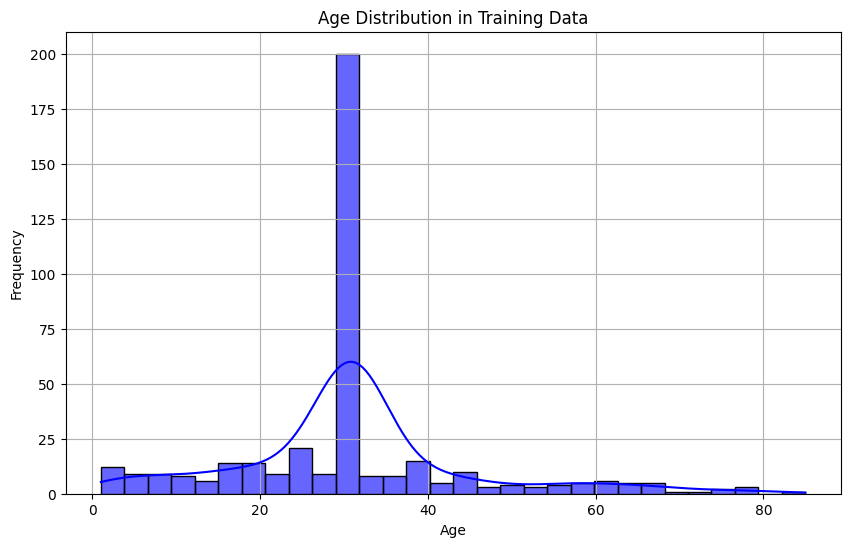

In [9]:
# We can viz some patterns eg patient age, age distribution
# But first let's fill missing values in the patient age column
train_df['Patient_Age'].fillna(train_df['Patient_Age'].mean(), inplace=True)

test_df['Patient_Age'].fillna(test_df['Patient_Age'].mean(), inplace=True)

# Plotting age distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Patient_Age'], bins=30, kde=True, color='blue', alpha=0.6)
plt.title('Age Distribution in Training Data')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Model Training

In [10]:
def preprocess_clinical_text(text):
    """Process text according to competition requirements:
    1. Convert to lowercase
    2. Remove punctuation
    3. Replace paragraphs with spaces
    """
    if pd.isna(text):
        return "no prediction available"
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove punctuation (except apostrophes)
    text = re.sub(r'[^\w\s\']', '', text)
    
    # Replace paragraphs (newlines) with spaces
    text = re.sub(r'\n+', ' ', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

## Helper Function for Model Training

In [11]:
def prepare_input_for_model(row):
    """Create enhanced input by combining prompt with additional context."""
    prompt = row['Prompt']
    
    # Add structured information about the patient and scenario
    additional_context = []
    
    if not pd.isna(row['Patient_Age']):
        additional_context.append(f"Patient age: {int(row['Patient_Age'])}")
    
    if row['Patient_Gender'] != 'Unknown':
        additional_context.append(f"Patient gender: {row['Patient_Gender']}")
    
    # Add facility complexity
    facility_levels = {0: 'Basic', 1: 'Medium', 2: 'High', 3: 'Advanced'}
    additional_context.append(f"Facility level: {facility_levels.get(row['Facility_Complexity'], 'Unknown')}")
    
    # Add key medical conditions
    if len(row['Medical_Keywords']) > 0:
        conditions = ", ".join(row['Medical_Keywords'])
        additional_context.append(f"Key conditions: {conditions}")
    
    # Build the enhanced prompt
    enhanced_prompt = prompt + "\n\nAdditional context:\n" + "\n".join(additional_context)
    
    return enhanced_prompt

## Transformer Dataset Creation Function

In [12]:
import torch
from datasets import Dataset
from transformers import AutoTokenizer

def create_transformer_dataset(inputs, targets, tokenizer, max_length=512):
    """Create a dataset for training the transformer model."""
    input_encodings = tokenizer(
        inputs, 
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"
    )
    
    target_encodings = tokenizer(
        targets,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"
    )
    
    dataset = {
        'input_ids': input_encodings.input_ids,
        'attention_mask': input_encodings.attention_mask,
        'labels': target_encodings.input_ids.clone()
    }
    
    # Replace padding token id with -100 so it's ignored in loss calculation
    dataset['labels'][dataset['labels'] == tokenizer.pad_token_id] = -100
    
    return Dataset.from_dict(dataset)

## Model Training Pipeline

In [15]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, DataCollatorForSeq2Seq
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
import torch
!pip install evaluate
import evaluate
!pip install rouge_score
from rouge_score import rouge_scorer
from sklearn.model_selection import train_test_split

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model - using smaller model for memory efficiency
try:
    model_name = "google/flan-t5-small"  # Memory efficient model
    print(f"Loading {model_name} model...")
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
    
    # Add a special token for target text
    tokenizer.add_special_tokens({'additional_special_tokens': ['<target>']})
    
    # IMPORTANT: Resize embeddings after adding tokens
    model.resize_token_embeddings(len(tokenizer))
    
    print(f"Successfully loaded {model_name} model")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Consider trying a different model or approach.")

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=7ca4349d60f569b482c2570a66a2cf6f62f1a9a0493dee3e614ced413fa5ba15
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
Using device: cuda
Loading google/flan-t5-small model...


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Successfully loaded google/flan-t5-small model


In [16]:
# Split the training data into training and validation sets
train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    train_df,
    train_df['Clinician'].apply(preprocess_clinical_text),
    test_size=0.15,
    random_state=42
)

# Prepare enhanced inputs for training
train_enhanced_inputs = [prepare_input_for_model(row) for _, row in train_inputs.iterrows()]
val_enhanced_inputs = [prepare_input_for_model(row) for _, row in val_inputs.iterrows()]

# Convert target strings to lists
train_targets_list = train_targets.tolist()
val_targets_list = val_targets.tolist()

print(f"Training samples: {len(train_enhanced_inputs)}")
print(f"Validation samples: {len(val_enhanced_inputs)}")

# Show example of enhanced input and target
print("\nExample of enhanced input:")
print("-" * 80)
print(train_enhanced_inputs[0][:300] + "...")
print("-" * 80)

print("\nTarget output:")
print("-" * 80)
print(train_targets_list[0][:300] + "...")
print("-" * 80)

# Create datasets for training
train_dataset = create_transformer_dataset(
    train_enhanced_inputs, 
    train_targets_list, 
    tokenizer
)

val_dataset = create_transformer_dataset(
    val_enhanced_inputs, 
    val_targets_list, 
    tokenizer
)

Training samples: 340
Validation samples: 60

Example of enhanced input:
--------------------------------------------------------------------------------
i am a nurse with 8 years of experience in general nursing working in a health centres in kakamega county in kenya 14 years old girl came with malaise fever chills she completed al full dose one day ago investigation done bs for mps was negative salmonella type 3 not done pregnancy test negative the...
--------------------------------------------------------------------------------

Target output:
--------------------------------------------------------------------------------
treatment last menstrual period started 2 days ago investigations bs for mps negative pregnancy test negative salmonella type 3 not done management administer iv fluids for hydration antipyretics for fever investigate thoroughly to find cause blood slide for malarial parasites salmonella cultures bl...
------------------------------------------------------------

## Training Arguments and Trainer

In [17]:
# Set up ROUGE scorer for evaluation
rouge = evaluate.load('rouge')

def compute_metrics(eval_pred):
    """Calculate ROUGE scores for evaluation."""
    predictions, labels = eval_pred
    
    # Decode predictions
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Replace -100 with pad token id to properly decode labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Compute ROUGE scores
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    
    # Format results for clarity
    result = {k: round(v * 100, 2) for k, v in result.items() if '*' not in k}
    return result

# Set up data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True
)

# Define training arguments with memory optimizations
training_args = TrainingArguments(
    output_dir="./kenya_clinical_model",
    per_device_train_batch_size=2,      # Small batch size for memory efficiency
    per_device_eval_batch_size=2,       
    gradient_accumulation_steps=8,      # Accumulate gradients to simulate larger batch
    gradient_checkpointing=True,        # Trade compute for memory
    fp16=torch.cuda.is_available(),     # Mixed precision if available
    
    # Training schedule
    num_train_epochs=3,                 # Train for more epochs
    warmup_steps=100,
    weight_decay=0.01,
    
    # Evaluation and saving strategy
    eval_strategy="steps",        
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    save_total_limit=2,                 # Keep only the 2 best checkpoints
    load_best_model_at_end=True,
    metric_for_best_model="rouge1",
    greater_is_better=True,
    
    # Logging
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",                  # Disable wandb/tensorboard reporting
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [18]:
# Train the model
print("Starting model training...")
try:
    trainer.train()
    print("Training complete!")
except Exception as e:
    print(f"Error during training: {e}")

Starting model training...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss


Training complete!


## Evaluation

In [19]:
def evaluate_model(model, validation_inputs, validation_targets, tokenizer, num_examples=5):
    """Evaluate the model and show examples of predictions."""
    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    # Select a few examples to display
    indices = np.random.choice(len(validation_inputs), min(num_examples, len(validation_inputs)), replace=False)
    
    # Calculate ROUGE scores for each example
    rouge_scores = []
    
    print("Evaluating model on sample validation examples...")
    
    for i, idx in enumerate(indices):
        input_text = validation_inputs[idx]
        reference = validation_targets.iloc[idx]
        
        # Tokenize input
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).to(device)
        
        # Generate prediction
        with torch.no_grad():
            output_ids = model.generate(
                inputs.input_ids,
                max_length=512,
                num_beams=4,
                temperature=0.7,
                early_stopping=True
            )
        
        # Decode prediction
        prediction = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        prediction = preprocess_clinical_text(prediction)
        
        # Calculate ROUGE scores
        scores = scorer.score(reference, prediction)
        rouge_scores.append({
            'rouge1': scores['rouge1'].fmeasure,
            'rouge2': scores['rouge2'].fmeasure,
            'rougeL': scores['rougeL'].fmeasure
        })
        
        # Print example
        print(f"\nExample {i+1}:")
        print("-" * 40)
        print(f"Input:\n{input_text[:100]}...")
        print("\nReference:\n{reference[:100]}...")
        print("\nPrediction:\n{prediction[:100]}...")
        print("\nROUGE Scores:")
        print(f"ROUGE-1: {rouge_scores[-1]['rouge1']:.4f}")
        print(f"ROUGE-2: {rouge_scores[-1]['rouge2']:.4f}")
        print(f"ROUGE-L: {rouge_scores[-1]['rougeL']:.4f}")
    
    # Calculate average scores
    avg_rouge1 = np.mean([score['rouge1'] for score in rouge_scores])
    avg_rouge2 = np.mean([score['rouge2'] for score in rouge_scores])
    avg_rougeL = np.mean([score['rougeL'] for score in rouge_scores])
    
    print(f"\nAverage ROUGE Scores across {len(indices)} examples:")
    print(f"ROUGE-1: {avg_rouge1:.4f}")
    print(f"ROUGE-2: {avg_rouge2:.4f}")
    print(f"ROUGE-L: {avg_rougeL:.4f}")
    
    return rouge_scores

# Evaluate the model
rouge_scores = evaluate_model(
    model, 
    val_enhanced_inputs, 
    val_targets,
    tokenizer,
    num_examples=5
)

Evaluating model on sample validation examples...

Example 1:
----------------------------------------
Input:
i am a nurse working in a health centres in kakamega county in kenya a child is brought to mch with ...

Reference:
{reference[:100]}...

Prediction:
{prediction[:100]}...

ROUGE Scores:
ROUGE-1: 0.0000
ROUGE-2: 0.0000
ROUGE-L: 0.0000

Example 2:
----------------------------------------
Input:
i am a nurse with 9 years of experience in general nursing working in a sub county hospitals and nur...

Reference:
{reference[:100]}...

Prediction:
{prediction[:100]}...

ROUGE Scores:
ROUGE-1: 0.0000
ROUGE-2: 0.0000
ROUGE-L: 0.0000

Example 3:
----------------------------------------
Input:
i am a nurse with 20 years of experience in general nursing working in a national referral hospitals...

Reference:
{reference[:100]}...

Prediction:
{prediction[:100]}...

ROUGE Scores:
ROUGE-1: 0.0000
ROUGE-2: 0.0000
ROUGE-L: 0.0000

Example 4:
----------------------------------------
Input:
i am 

In [20]:
def generate_test_predictions(model, test_df):
    """Generate predictions for test data."""
    print("Generating predictions for test data...")
    
    # Create enhanced inputs for test data
    test_enhanced_inputs = [prepare_input_for_model(row) for _, row in test_df.iterrows()]
    
    # Initialize lists to store predictions and IDs
    predictions = []
    ids = []
    
    # Generate predictions
    for idx, (enhanced_input, row) in enumerate(zip(test_enhanced_inputs, test_df.iterrows())):
        # Tokenize input
        inputs = tokenizer(enhanced_input, return_tensors="pt", truncation=True, max_length=512).to(device)
        
        # Generate prediction
        with torch.no_grad():
            try:
                output_ids = model.generate(
                    inputs.input_ids,
                    max_length=512,
                    num_beams=4,
                    temperature=0.7,
                    do_sample=True,
                    early_stopping=False
                )
            except Exception as e:
                print(f"Error generating prediction for sample {idx}: {e}")
                # If generation fails, use a default prediction
                predictions.append("no prediction available")
                ids.append(row[1]['Master_Index'])
                continue
        
        # Decode prediction
        try:
            prediction = tokenizer.decode(output_ids[0], skip_special_tokens=True)
            # Process according to challenge requirements
            prediction = preprocess_clinical_text(prediction)
        except Exception as e:
            print(f"Error decoding prediction for sample {idx}: {e}")
            prediction = "no prediction available"
        
        # Save prediction and ID
        predictions.append(prediction)
        ids.append(row[1]['Master_Index'])
        
        # Progress update
        if (idx + 1) % 10 == 0:
            print(f"Generated {idx + 1}/{len(test_df)} predictions")
    
    # Create submission DataFrame
    submission_df = pd.DataFrame({
        'Master_Index': ids,
        'Clinician': predictions
    })
    
    return submission_df

# Generate test predictions
submission_df = generate_test_predictions(model, test_df)

Generating predictions for test data...
Generated 10/100 predictions
Generated 20/100 predictions
Generated 30/100 predictions
Generated 40/100 predictions
Generated 50/100 predictions
Generated 60/100 predictions
Generated 70/100 predictions
Generated 80/100 predictions
Generated 90/100 predictions
Generated 100/100 predictions


In [22]:
def save_submission(submission_df, filename="kenya_clinical_submission.csv"):
    """Save the submission DataFrame to a CSV file with proper validation."""
    # Ensure columns match the sample submission format
    try:
        sample_submission = pd.read_csv('/kaggle/input/kenya-clinical/SampleSubmission.csv')
        required_columns = sample_submission.columns.tolist()
        
        # Check if all test IDs are in our submission
        missing_ids = set(sample_submission['Master_Index']) - set(submission_df['Master_Index'])
        if missing_ids:
            print(f"Warning: Missing predictions for {len(missing_ids)} IDs")
            # Add missing IDs with a default prediction
            for missing_id in missing_ids:
                submission_df = pd.concat([submission_df, pd.DataFrame({
                    'Master_Index': [missing_id],
                    'Clinician': ['no prediction available']
                })], ignore_index=True)
            print(f"Added default predictions for {len(missing_ids)} missing IDs")
    except FileNotFoundError:
        print("SampleSubmission.csv not found, skipping ID validation")
        required_columns = ['Master_Index', 'Clinician']
    
    # Check if columns match
    if set(submission_df.columns) != set(required_columns):
        print(f"Warning: Submission columns {submission_df.columns.tolist()} don't match required columns {required_columns}")
        
        # Ensure we have the right columns in the right order
        for col in required_columns:
            if col not in submission_df.columns:
                submission_df[col] = "no prediction available"
        
        submission_df = submission_df[required_columns]
    
    # Check for missing values
    null_counts = submission_df.isnull().sum()
    if null_counts.sum() > 0:
        print(f"Warning: Found {null_counts.sum()} missing values in submission")
        # Fill missing values with default
        submission_df.fillna('no prediction available', inplace=True)
    
    # Save the file
    submission_df.to_csv(filename, index=False)
    print(f"Submission saved to {filename}")
    
    # Show first few rows
    print("\nFirst rows of submission file:")
    print(submission_df.head())

# Save the submission
save_submission(submission_df)

Submission saved to kenya_clinical_submission.csv

First rows of submission file:
  Master_Index Clinician
0     ID_CUAOY          
1     ID_OGSAY         3
2     ID_TYHSA          
3     ID_CZXLD    căt qq
4     ID_ZJQUQ          


In [23]:
def generate_simple_predictions(test_df):
    """Generate template-based predictions for different medical conditions."""
    print("Generating template-based predictions as fallback...")
    
    # Create template responses based on extracted conditions
    predictions = []
    
    for _, row in test_df.iterrows():
        conditions = row['Medical_Keywords']
        is_emergency = row['Is_Emergency']
        is_pediatric = row['Is_Pediatric']
        
        if is_emergency:
            base = "diagnosis requiring urgent medical attention "
        else:
            base = "diagnosis based on presented symptoms "
        
        if 'fever' in conditions:
            if is_pediatric:
                pred = base + "likely viral infection rule out malaria treatment antipyretics fluids supportive care monitor for improvement refer if worsening"
            else:
                pred = base + "consider malaria typhoid viral infection treatment paracetamol fluids investigations blood tests malaria test complete blood count"
        
        elif 'cough' in conditions:
            if is_pediatric:
                pred = base + "respiratory tract infection consider pneumonia treatment supportive care fluids antipyretics antibiotics review after treatment"
            else:
                pred = base + "upper respiratory tract infection consider tuberculosis assessment investigations sputum test chest xray treatment based on findings"
        
        elif 'pain' in conditions:
            pred = base + "assess for source of pain provide analgesia investigations based on location of pain follow up to monitor response to treatment"
        
        elif 'bleeding' in conditions:
            pred = base + "urgent stabilization establish source of bleeding surgical consult maintain airway breathing circulation monitor vital signs"
        
        elif 'hypertension' in conditions:
            pred = base + "blood pressure control medications lifestyle modification regular monitoring follow up dietary advice sodium restriction"
        
        else:
            # Default fallback
            pred = base + "complete assessment investigations based on symptoms manage symptomatically refer if no improvement monitor response to treatment"
        
        # Process according to challenge requirements
        pred = preprocess_clinical_text(pred)
        predictions.append(pred)
    
    # Create submission dataframe
    submission_df = pd.DataFrame({
        'Master_Index': test_df['Master_Index'].tolist(),
        'Clinician': predictions
    })
    
    return submission_df

# If model training fails, use this as a fallback
fallback_submission = generate_simple_predictions(test_df)
save_submission(fallback_submission, "fallback_submission.csv")

Generating template-based predictions as fallback...
Submission saved to fallback_submission.csv

First rows of submission file:
  Master_Index                                          Clinician
0     ID_CUAOY  diagnosis based on presented symptoms assess f...
1     ID_OGSAY  diagnosis based on presented symptoms complete...
2     ID_TYHSA  diagnosis based on presented symptoms complete...
3     ID_CZXLD  diagnosis based on presented symptoms complete...
4     ID_ZJQUQ  diagnosis based on presented symptoms likely v...
